## makemore: part 5.b

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
from dataclasses import dataclass

# build the dataset
block_size = 8  # context length: how many characters do we take to predict the next one?

@dataclass
class Dataset:
    x: torch.tensor
    y: torch.tensor

@dataclass
class Datasets:
    train: Dataset
    dev: Dataset
    test: Dataset

def build_dataset(words) -> Dataset:
    xs, ys = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:] + [ix]  # crop and append

    ds = Dataset(torch.tensor(xs), torch.tensor(ys))
    print(ds.x.shape, ds.y.shape)
    return ds

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
datasets = Datasets(
    build_dataset(words[:n1]),    # 80%,
    build_dataset(words[n1:n2]),  # 10%
    build_dataset(words[n2:])     # 10%
)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x, y in zip(datasets.train.x[:20], datasets.train.y[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [8]:
from abc import ABC, abstractmethod

torch.manual_seed(42)


class Layer(ABC):
    def __init__(self):
        self.training = True
        self.out = None

    @abstractmethod
    def __call__(self, x: torch.Tensor):
        pass
    
    def backward(self):
        for p in self.parameters():
            p.grad = None

    @abstractmethod
    def parameters(self):
        return []


class Linear(Layer):
    def __init__(self, fan_in, fan_out, bias=False):
        super().__init__()
        self.w = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.b = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.Tensor):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.w] + ([self.b] if self.b is not None else [])


class Tanh(Layer):
    def __call__(self, x: torch.Tensor):
        # print(f'Applying Tanh layer: x ({x.shape})')
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding(Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        self.w = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, x: torch.Tensor):
        self.out = self.w[x]
        return self.out

    def parameters(self):
        return [self.w]
    
    
class Flatten(Layer):
    def __init__(self):
        super().__init__()

    def __call__(self, x: torch.Tensor):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []


class BatchNorm1d(Layer):
    def __init__(self, n_dims: int, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        super().__init__()
        # parameters
        self.gain = torch.ones(n_dims)
        self.bias = torch.zeros(n_dims)
        # buffers
        self.running_mean = torch.zeros(n_dims)
        self.running_var = torch.ones(n_dims)

    def __call__(self, x: torch.Tensor):
        if self.training:
            assert x.shape[0] > 1, 'Minibatch size must be larger than 1'
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / (xvar + self.eps) ** 0.5
        # normalise to a unit gaussian
        self.out = xhat * self.gain + self.bias
        
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gain, self.bias]


class Sequential:
    def __init__(self, layers: list[Layer]):
        self.layers = layers
        self.out = None
        
    def __call__(self, x: torch.Tensor, training: bool = False) -> torch.Tensor:
        for l in self.layers:
            l.training = training
            x = l(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]


n_hidden = 128
emb_dims = 10

model = Sequential([
    Embedding(vocab_size, emb_dims),
    Flatten(),
    Linear(block_size * emb_dims, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
])
with torch.no_grad():
    if isinstance(model.layers[-1], BatchNorm1d):
        model.layers[-1].gain *= 0.1
    if isinstance(model.layers[-1], Linear):
        model.layers[-1].w *= 0.1
    
    for l in model.layers:
        if isinstance(l, Linear):
            # tanh is a shrinking function, so need to initialise wights a bit larger
            # to compensate this shrinkage and keep weights a unit gaussian on each step
            l.w *= 5/3

for p in model.parameters():
    p.requires_grad = True
print('Total model parameters:', sum(p.nelement() for p in model.parameters()))


Total model parameters: 14276


In [9]:
DEBUG = False

from collections import defaultdict

n_steps = 1
batch_size = 32
learning_rate = 0.1

# stats
linear_w_update_rates_by_layer = defaultdict(list)
losses = []
tanh_outs = []


for step_i in range(n_steps):
    batch_ix = torch.randint(high=datasets.train.x.shape[0], size=(batch_size,))
    logits = model(datasets.train.x[batch_ix], training=True)
    loss = F.cross_entropy(logits, datasets.train.y[batch_ix])
    
    if DEBUG:
        for l in model.layers:
            l.out.retain_grad()

    if n_steps == 1 or step_i % (n_steps // 10) == 0:
        print(f'Step {step_i}: training loss: {loss.item()}')
    losses.append(loss.item())

    for p in model.parameters():
        p.grad = None
    loss.backward()

    lr = learning_rate if (step_i < (n_steps / 2)) else learning_rate / 10
    for p in model.parameters():
        p.data -= lr * p.grad

    if DEBUG:
        with torch.no_grad():
            for li, l in enumerate(model.layers):
                ps = [p for p in l.parameters() if len(p.shape) == 2]
                if ps:
                    linear_w_update_rates_by_layer[li].append(
                        (lr * ps[0].grad.std() / ps[0].data.std()).abs().log10().item()
                    )
                if isinstance(l, Tanh) and (n_steps == 1 or step_i % (n_steps // 10) == 0):
                    tanh_outs.append(l.out)


@torch.no_grad()
def loss_for_split(split: str):
    ds = datasets.__getattribute__(split)
    logits = model(ds.x)
    loss = F.cross_entropy(logits, ds.y)
    print(f'{split} loss={loss}')

if not DEBUG:
    loss_for_split('train')
    loss_for_split('test')
    loss_for_split('dev')


Step 0: training loss: 3.273597240447998
train loss=3.298344850540161
test loss=3.29842209815979
dev loss=3.2997186183929443


Reshaped: torch.Size([1000, 10]), means shape: torch.Size([1000])


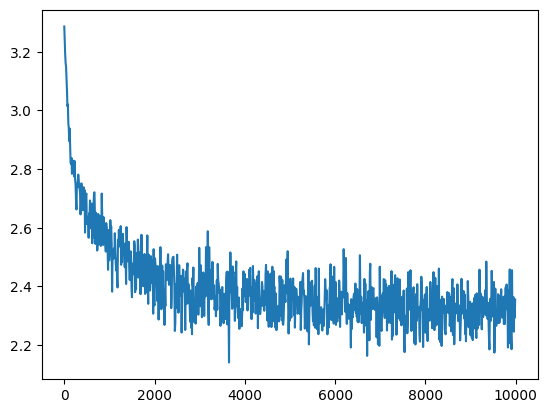

In [656]:
# e.g. for 10_000 steps, it would be 10, so we plot every 10 steps
window_size = n_steps // 1000
# taking mean for every 10 steps
t = torch.tensor(losses[:-1]).view(-1, window_size)
print(f'Reshaped: {t.shape}, means shape: {t.mean(1).shape}')
plt.plot(torch.arange(len(t)) * window_size, t.mean(1));

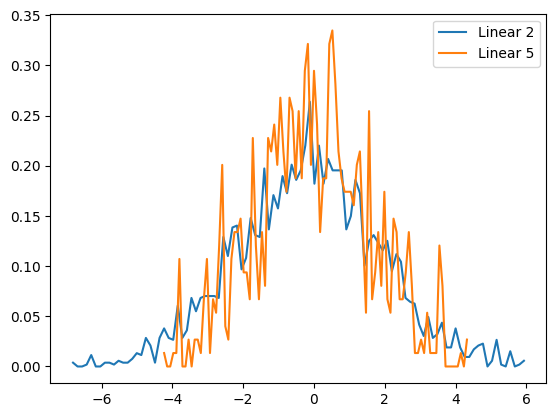

In [662]:
# Linear layers outs should stay close to unit gaussian. If they are not,
# it means that the initialisation is wrong, and/or batch norm is wrong.
legends = []
for li, l in enumerate(model.layers):
    if isinstance(l, Linear):
        hy, hx = torch.histogram(l.out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{l.__class__.__name__} {li}')
plt.legend(legends);

step 0   : t.mean().item()=+0.0048  t.std().item()=+0.6384  +0.0256
step 1000: t.mean().item()=+0.0003  t.std().item()=+0.6436  +0.0171
step 2000: t.mean().item()=-0.0015  t.std().item()=+0.6410  +0.0256
step 3000: t.mean().item()=+0.0011  t.std().item()=+0.6388  +0.0278
step 4000: t.mean().item()=-0.0056  t.std().item()=+0.6443  +0.0325
step 5000: t.mean().item()=-0.0030  t.std().item()=+0.6465  +0.0352
step 6000: t.mean().item()=-0.0020  t.std().item()=+0.6479  +0.0376
step 7000: t.mean().item()=+0.0006  t.std().item()=+0.6419  +0.0405
step 8000: t.mean().item()=-0.0093  t.std().item()=+0.6526  +0.0364
step 9000: t.mean().item()=-0.0080  t.std().item()=+0.6554  +0.0354
step 10000: t.mean().item()=-0.0059  t.std().item()=+0.6490  +0.0383


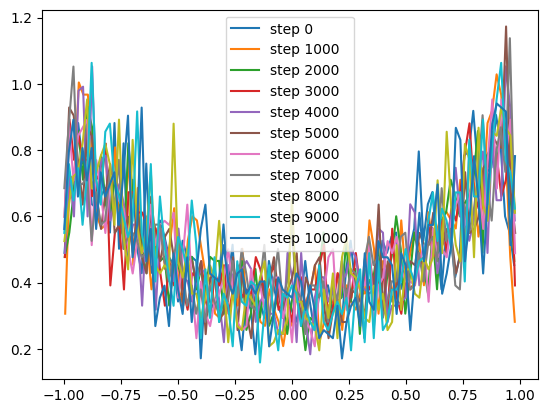

In [664]:
# Hist of tanh outputs over time. 
# Tanh of a gaussian with long tails will have peaks close to -1 and 1, 
# meaning that such neurons won't train and will saturate i.e. any small 
# change to a large input of tanh wouldn't change the output.
# So we should not expect to see very high peaks of tanh.
legends = []
for i, t in enumerate(tanh_outs):
    legends.append(f'step {i * (n_steps // 10)}')
    counts, xs = torch.histogram(t, density=True)
    plt.plot(xs[:-1].detach(), counts.detach())

    sat = (t.abs() > 0.97).float().mean().item()
    print(f'step {i * (n_steps // 10):<4}: {t.mean().item()=:+.4f}  {t.std().item()=:+.4f}  {sat:+.4f}')
plt.legend(legends);

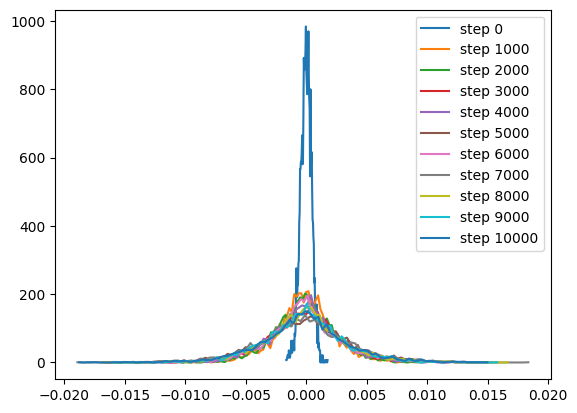

In [665]:
# Histogram of tanh output gradients. Following the reasoning above, we 
# shouldn't see a lot at zero.
legends = []
for i, t in enumerate(tanh_outs):
    counts, xs = torch.histogram(t.grad, density=True)
    plt.plot(xs[:-1].detach(), counts.detach())
    legends.append(f'step {i * (n_steps // 10)}')
plt.legend(legends);

weight (27, 10)  : mean: -0.0000, std: 0.0155, grad:data: -0.0133
weight (30, 128) : mean: -0.0001, std: 0.0116, grad:data: +0.0025
weight (128, 27) : mean: -0.0001, std: 0.0146, grad:data: +0.0120


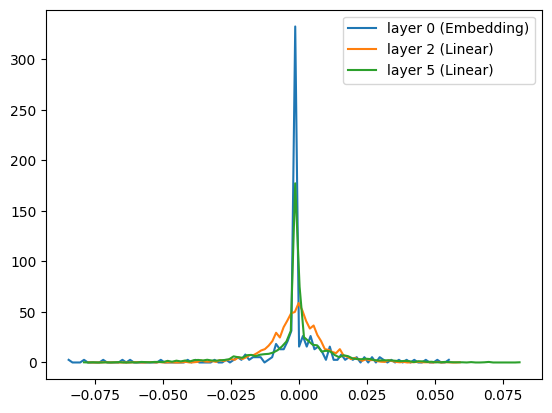

In [666]:
# Histogram of weights gradients for each layer (not over time).
legends = []
for li, l in enumerate(model.layers):
    if isinstance(l, Linear) or isinstance(l, Embedding):
        print(
            f'weight {str(tuple(l.w.shape)):<10}: '
            f'mean: {l.w.grad.mean().item():+.4f}, std: {l.w.grad.std().item():.4f}, '
            f'grad:data: {(l.w.grad / l.w.data).mean().item():+.4f}'
        )
        w_grad_count, w_grad = torch.histogram(l.w.grad, density=True)
        plt.plot(w_grad[:-1].detach(), w_grad_count.detach())
        legends.append(f'layer {li} ({l.__class__.__name__})')
plt.legend(legends);

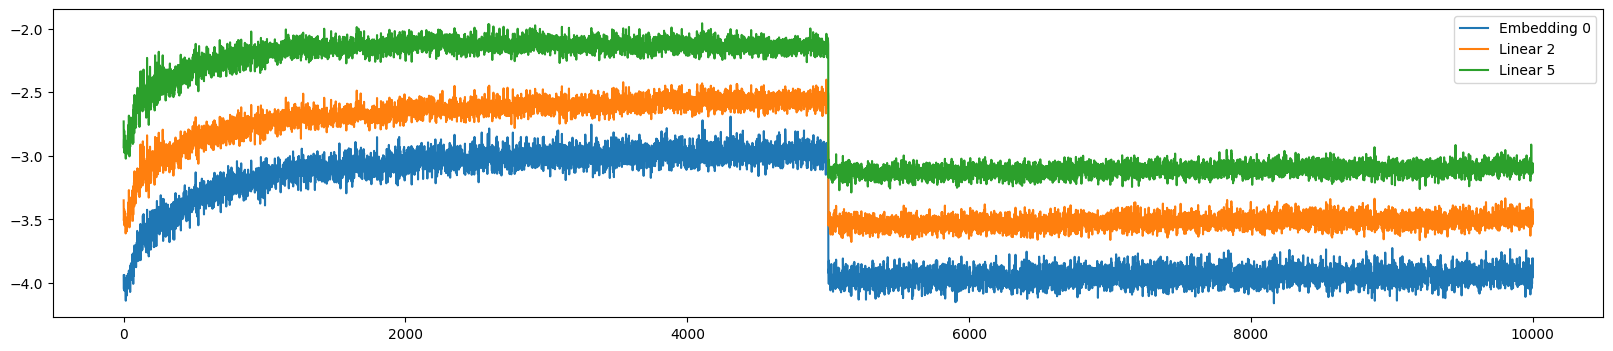

In [667]:
# Plotting update rate over step, for each layer. Ideal update rate should be 
# around 1/1000 which corresponds to the factor of -3 on the plot. Meaning, 
# that the update (learning rate std times gradient std?) is 1/1000th of data.
plt.figure(figsize=(20, 4))
legends = []
for li, l in enumerate(model.layers):
    if isinstance(l, Linear) or isinstance(l, Embedding):
        t = linear_w_update_rates_by_layer[li]
        plt.plot(t)
        legends.append(f'{l.__class__.__name__} {li}')
plt.plot([0, len(linear_w_update_rates_by_layer[1])], [-3, -3], 'k')
plt.legend(legends);


In [668]:
# sample from the model
max_words = 20
max_word_len = 20
for _ in range(max_words):
    out = []
    context = [0] * block_size
    for _ in range(max_word_len):
        x = torch.tensor([context])
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        assert torch.all(probs >= 0), logits
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[ix] for ix in out))


baperia.
olsh.
nastyegella.
norilah.
mais.
ana.
katviughanan.
zara.
nibh.
vuri.
rajeasettastym.
kan.
jen.
eri.
sha.
eligar.
camochlesh.
daraz.
ady.
wamika.
